In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

In [5]:
data = sio.loadmat("/mnt/c/Users/ankku/Documents/IITB Lectures and Study Material/Sem6/CS736/assignmentImageDenoising/data/assignmentImageDenoising_phantom.mat")
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jan 27 00:08:21 2021',
 '__version__': '1.0',
 '__globals__': [],
 'imageNoiseless': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], shape=(256, 256)),
 'imageNoisy': array([[0.07629282, 0.04101627, 0.04163587, ..., 0.01189836, 0.0873605 ,
         0.09791722],
        [0.15772573, 0.09203495, 0.05365298, ..., 0.04588094, 0.08237965,
         0.07951305],
        [0.08702026, 0.06584775, 0.10950586, ..., 0.07184091, 0.06234213,
         0.01285985],
        ...,
        [0.10773612, 0.03931808, 0.02140435, ..., 0.09017235, 0.03618134,
         0.09753391],
        [0.03713503, 0.12452628, 0.09834595, ..., 0.0618332 , 0.0792185 ,
         0.08058026],
        [0.06459982, 0.11885759, 0.08043875, ..., 0.10814008, 0.03359

In [6]:
noisy_img = data['imageNoisy']
noisy_img = (noisy_img - noisy_img.min()) / (noisy_img.max() - noisy_img.min())
noiseless_img = data['imageNoiseless']

In [7]:
noiseless_img.min(), noiseless_img.max()

(np.float64(0.0), np.float64(1.0))

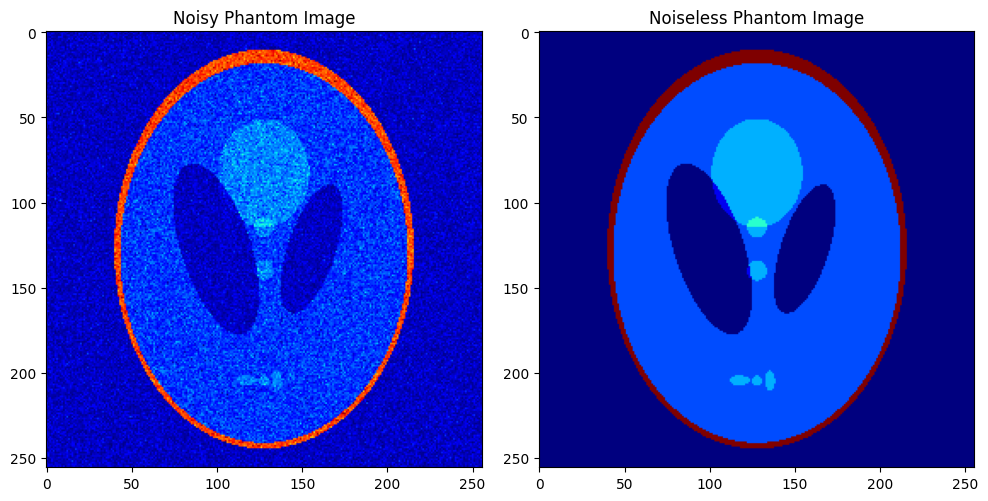

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(np.abs(noisy_img), cmap='jet')
axes[0].set_title("Noisy Phantom Image")

axes[1].imshow(np.abs(noiseless_img), cmap='jet')
axes[1].set_title("Noiseless Phantom Image")

plt.tight_layout()
plt.show()

In [9]:
def get_neighbors(img):
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    neighbors = np.stack([np.roll(img, shift, axis) for shift, axis in [(1, 0), (-1, 0), (0, 1), (0, -1)]], axis=0)
    return neighbors

In [10]:
def quadratic_prior(u, param):
    return np.abs(u)**2

In [11]:
def quadratic_prior_grad(u, param):
    return 2*np.abs(u)

In [12]:
def huber_prior(u, delta):
    return np.where(np.abs(u) <= delta, 0.5 * u**2, delta * (np.abs(u) - 0.5 * delta))

In [13]:
def huber_prior_grad(u, delta):
    return np.where(np.abs(u) <= delta, u, delta * np.sign(u))

In [14]:
def discontinuity_adaptive_prior(u, lambda_):
    return lambda_*np.abs(u) - lambda_**2*np.log(1+(np.abs(u)/lambda_))

In [15]:
def discontinuity_adaptive_prior_grad(u, lambda_):
    return lambda_*np.sign(u) - lambda_**2*(1/(1+(np.abs(u)/lambda_)))*(np.sign(u)/lambda_)

In [95]:
def compute_update_quad(img, prior_func_grad, param, weight=1):
    neighbors = get_neighbors(img)
    diff = img[None, :, :] - neighbors
    prior_grad = np.mean(prior_func_grad(diff, param), axis=0)
    likelihood_grad = img - noisy_img
    return -weight * likelihood_grad - (1 - weight) * prior_grad

In [96]:
def denoise_image_quad(noisy_img, prior_func, prior_func_grad, param=None, weight=1, max_iter=500):
    img = noisy_img.copy()
    obj_values = []
    step_size = 20
    velocity = np.zeros_like(img)
    beta = 0.99
    for i in range(max_iter):
        update = compute_update_quad(img, prior_func_grad, param, weight)
        velocity = beta * velocity + (1 - beta) * update
        img_new = img + step_size * velocity
        img_new = (img_new-img_new.min())/(img_new.max()-img_new.min())

        likelihood_term = np.sum((img_new - noisy_img) ** 2)  # Gaussian noise

        prior_term = np.sum(prior_func(get_neighbors(img_new) - img_new[None, :, :], param)) 
        obj_new = -weight * likelihood_term - (1 - weight) * prior_term  # Log posterior
        
        if not obj_values or obj_new > obj_values[-1]:
            step_size *= 1.1  
            img=img_new
            obj_values.append(obj_new)
        else:
            step_size *= 0.8 
    
    return img, obj_values

In [97]:
quad_denoised, quad_obj = denoise_image_quad(noisy_img, quadratic_prior, quadratic_prior_grad, None)
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))
rrmse_noisy = rrmse(noiseless_img, noisy_img)
rrmse_quad = rrmse(noiseless_img, quad_denoised)
print(rrmse_noisy, rrmse_quad)

0.29311377574241915 0.29311377574241915


In [90]:
def compute_update_huber(img, prior_func_grad, param, weight=0.12):
    neighbors = get_neighbors(img)
    diff = img[None, :, :] - neighbors
    prior_grad = np.mean(prior_func_grad(diff, param), axis=0)
    likelihood_grad = img - noisy_img
    return -weight * likelihood_grad - (1 - weight) * prior_grad

In [91]:
def denoise_image_huber(noisy_img, prior_func, prior_func_grad, param=None, weight=0.12, max_iter=500):
    img = noisy_img.copy()
    obj_values = []
    step_size = 20
    velocity = np.zeros_like(img)
    beta = 0.99
    for i in range(max_iter):
        update = compute_update_huber(img, prior_func_grad, param, weight)
        velocity = beta * velocity + (1 - beta) * update
        img_new = img + step_size * velocity
        img_new = (img_new-img_new.min())/(img_new.max()-img_new.min())

        likelihood_term = np.sum((img_new - noisy_img)**2)  #Gaussian noise
        prior_term = np.sum(prior_func(get_neighbors(img_new) - img_new[None, :, :], param))  
        obj_new = -weight * likelihood_term - (1 - weight) * prior_term  # Log posterior
        
        if not obj_values or obj_new > obj_values[-1]:
            step_size *= 1.05  
            img=img_new
            obj_values.append(obj_new)
        else:
            step_size *= 0.8  
    
    return img, obj_values

In [92]:
huber_denoised, huber_obj = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, 0.05)
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))
rrmse_noisy = rrmse(noiseless_img, noisy_img)
rrmse_huber = rrmse(noiseless_img, huber_denoised)
print(rrmse_noisy, rrmse_huber)

0.29311377574241915 0.19269340508701568


In [74]:
def compute_update_disc(img, prior_func_grad, param, weight=0.064):
    neighbors = get_neighbors(img)
    diff = img[None, :, :] - neighbors
    # prior_grad = np.mean(prior_func(diff, param), axis=0)
    prior_grad = np.mean(prior_func_grad(diff, param), axis=0)
    likelihood_grad = img - noisy_img
    return -weight * likelihood_grad - (1 - weight) * prior_grad

In [75]:
def denoise_image_disc(noisy_img, prior_func, prior_func_grad, param=None, weight=0.064, max_iter=500):
    img = noisy_img.copy()
    obj_values = []
    step_size = 20
    velocity = np.zeros_like(img)
    beta = 0.99
    for i in range(max_iter):
        update = compute_update_disc(img, prior_func_grad, param, weight)
        velocity = beta * velocity + (1 - beta) * update
        img_new = img + step_size * velocity
        img_new = (img_new-img_new.min())/(img_new.max()-img_new.min())

        likelihood_term = np.sum((img_new - noisy_img) ** 2)  #Gaussian noise
        prior_term = np.sum(prior_func(get_neighbors(img_new) - img_new[None, :, :], param))  
        obj_new = -weight * likelihood_term - (1 - weight) * prior_term  # Log posterior
        
        if not obj_values or obj_new > obj_values[-1]:
            step_size *= 1.7  
            img=img_new
            obj_values.append(obj_new)
        else:
            step_size *= 0.5  
    
    return img, obj_values

In [76]:
disc_denoised, disc_obj = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, 0.045)
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))
rrmse_noisy = rrmse(noiseless_img, noisy_img)
rrmse_disc = rrmse(noiseless_img, disc_denoised)
print(rrmse_noisy, rrmse_disc)

0.29311377574241915 0.19358051742914914


In [232]:
params = {'huber': 0.05, 'discont_adaptive': 0.06}
quad_denoised, quad_obj = denoise_image_quad(noisy_img, quadratic_prior, quadratic_prior_grad, None)
huber_denoised, huber_obj = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, params['huber'])
disc_denoised, disc_obj = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, params['discont_adaptive'])
print(f"Quad Denoised:\n {quad_denoised}\n Quad Obj:\n {quad_obj}")
print('\n')
print(f"Huber Denoised:\n {huber_denoised}\n Huber Obj:\n {huber_obj}")
print('\n')
print(f"Disc Denoised:\n {disc_denoised}\n Disc Obj:\n {disc_obj}")


Quad Denoised:
 [[0.06336747 0.03391831 0.03443556 ... 0.00961042 0.07260687 0.0814197 ]
 [0.13134836 0.07650913 0.04446754 ... 0.03797937 0.0684488  0.06605575]
 [0.07232283 0.05464784 0.091094   ... 0.05965098 0.05172132 0.01041309]
 ...
 [0.08961661 0.03250064 0.01754611 ... 0.07495422 0.02988207 0.08109971]
 [0.03067822 0.10363317 0.08177761 ... 0.05129645 0.06580985 0.06694666]
 [0.05360606 0.0989009  0.06682853 ... 0.08995384 0.02772062 0.04476296]]
 Quad Obj:
 [np.float64(-0.0)]


Huber Denoised:
 [[0.05303589 0.04152216 0.03121645 ... 0.03056364 0.03961321 0.04914189]
 [0.06394389 0.04451032 0.034182   ... 0.03339936 0.04128212 0.04604995]
 [0.05249412 0.03965489 0.03915354 ... 0.04329263 0.04038469 0.04060089]
 ...
 [0.04515165 0.03531695 0.02285975 ... 0.04846614 0.02461287 0.05698212]
 [0.03978326 0.05159525 0.0348636  ... 0.04367719 0.02969754 0.05319778]
 [0.04354515 0.05187479 0.03620095 ... 0.04360591 0.03000149 0.04627143]]
 Huber Obj:
 [np.float64(-171.7098356011135), 

In [98]:
def rrmse(A, B):
    return np.sqrt(np.sum((A - B) ** 2) / np.sum(A ** 2))
rrmse_noisy = rrmse(noiseless_img, noisy_img)
rrmse_quad = rrmse(noiseless_img, quad_denoised)
rrmse_huber = rrmse(noiseless_img, huber_denoised)
rrmse_disc = rrmse(noiseless_img, disc_denoised)
print(rrmse_noisy, rrmse_quad, rrmse_huber, rrmse_disc)

0.29311377574241915 0.29311377574241915 0.19269340508701568 0.19358051742914914


In [101]:
'''Used it for fine tuning'''
# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.1, 1, 10):  # Try different values
#     denoised_img, _ = denoise_image_quad(noisy_img, quadratic_prior, quadratic_prior_grad, None, p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter:", best_param)
# print("Optimal RRMSE:", best_rrmse)

'Used it for fine tuning'

In [102]:
'''Used it for fine tuning'''
# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.01, 0.1, 10):  # Try different values
#     denoised_img, _ = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter:", best_param)
# print("Optimal RRMSE:", best_rrmse)

'Used it for fine tuning'

In [103]:
'''Used it for fine tuning'''

# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.1, 1, 10):  # Try different values
#     denoised_img, _ = denoise_image_huber(noisy_img, huber_prior, huber_prior_grad, params['huber'], p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter:", best_param)
# print("Optimal RRMSE:", best_rrmse)

'Used it for fine tuning'

In [104]:
'''Used it for fine tuning'''

# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.1, 1, 10):  
#     denoised_img, _ = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, params['discont_adaptive'], p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter:", best_param)
# print("Optimal RRMSE:", best_rrmse)

'Used it for fine tuning'

In [105]:
'''Used it for fine tuning'''

# best_rrmse = float("inf")
# best_param = None
# for p in np.linspace(0.01, 0.1, 10):  # Try different values
#     denoised_img, _ = denoise_image_disc(noisy_img, discontinuity_adaptive_prior, discontinuity_adaptive_prior_grad, p)
#     rrmse_val = rrmse(noiseless_img, denoised_img)
#     if rrmse_val < best_rrmse:
#         best_rrmse = rrmse_val
#         best_param = p
# print("Optimal parameter:", best_param)
# print("Optimal RRMSE:", best_rrmse)

'Used it for fine tuning'

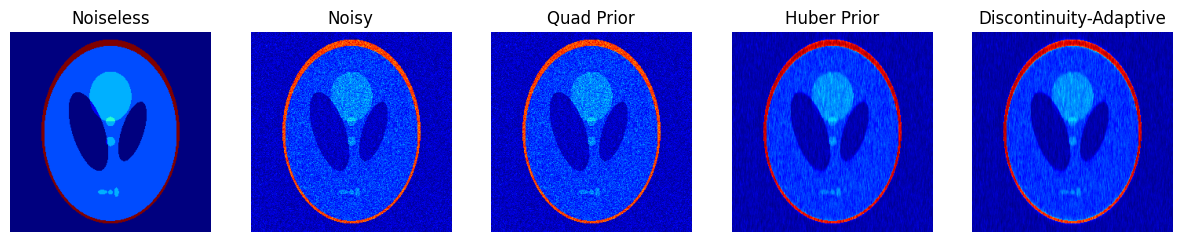

In [99]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for ax, img, title in zip(axs, [noiseless_img, noisy_img, quad_denoised, huber_denoised, disc_denoised],
                          ['Noiseless', 'Noisy', 'Quad Prior', 'Huber Prior', 'Discontinuity-Adaptive']):
    ax.imshow(np.abs(img), cmap='jet')
    ax.set_title(title)
    ax.axis('off')
plt.show()

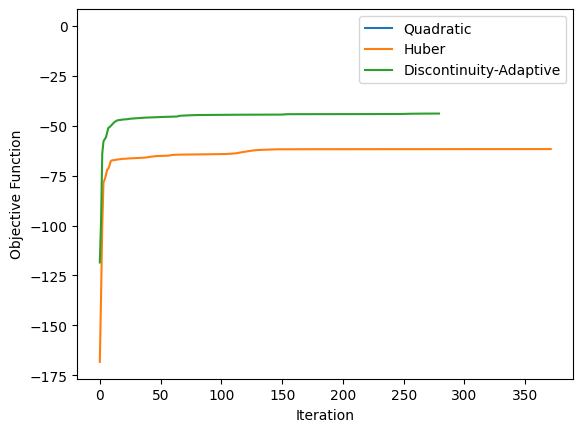

In [100]:
plt.figure()
plt.plot(quad_obj, label='Quadratic')
plt.plot(huber_obj, label='Huber')
plt.plot(disc_obj, label='Discontinuity-Adaptive')
plt.xlabel('Iteration')
plt.ylabel('Objective Function')
plt.legend()
plt.show()